In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from keras_contrib.layers.crf import CRF
import matplotlib.pyplot as plt
import os
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
import json
from keras import metrics
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Using TensorFlow backend.


In [2]:
sample_x = []
sample_y = []
vocabs = {'UNK'}
datas = []
for line in open('/home/wcb/nerXY/train_data/3.1_train.txt', 'r', encoding='utf-8'):
    line = line.rstrip().split('\t')
    if not line:
        continue
    char = line[0]
    if not char:
        continue
    cate = line[-1]
    sample_x.append(char)
    sample_y.append(cate)
    vocabs.add(char)
    if char in ['.', '?', '!']:
        datas.append([sample_x, sample_y])
        sample_x = []
        sample_y = []
word_dict = {wd:index for index,wd in enumerate(list(vocabs))}

In [3]:
file = open('/home/wcb/nerXY/word_dict/3.1_word_dict.txt', 'w') 
for k,v in word_dict.items():
    file.write(str(v) + ' ' + str(k) + '\n')
file.close()

In [4]:
class_dict = {'O':0,
              'I-MEM':1,
              'I-NMEM':2,
             }
x_train = [[word_dict[char] for char in data[0]] for data in datas]
y_train = [[class_dict[label] for label in data[1]] for data in datas]
x_train = pad_sequences(x_train, maxlen=40, padding='post')
y = pad_sequences(y_train, maxlen=40, padding='post')
y_train = np.expand_dims(y, axis=2)

In [5]:
embeddings_dict = {}
with open('/home/wcb/nerXY/w2v/3.1_w2v.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split(' ')
        if len(values) < 64:
            continue
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = coefs
print('Found %s word vectors.' % len(embeddings_dict))

embedding_matrix = np.zeros((len(word_dict) + 1, 64))
for word, i in word_dict.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 2061 word vectors.


In [6]:
model = Sequential()
embedding_layer = Embedding(len(word_dict) + 1,
                            64,
                            weights=[embedding_matrix],
                            input_length=40,
                            trainable=False,
                            mask_zero=True)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(8, return_sequences=True,  activation='softsign')))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(len(class_dict))))
crf_layer = CRF(len(class_dict), sparse_target=True)
model.add(crf_layer)
model.compile(optimizer='AdaGrad', loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])
model.summary()










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/Users/yvse/opt/anaconda3/envs/keras/lib/python3.7/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/yvse/opt/anaconda3/envs/keras/lib/python3.7/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 64)            132096    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 16)            4672      
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 16)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 3)             51        
_________________________________________________________________
crf_1 (CRF)                  (None, 40, 3)             27        
Total params: 136,846
Trainable params: 4,750
Non-trainable params: 132,096
_________________________________________________________________


In [7]:
history = model.fit(x_train[:], y_train[:], validation_split=0.10, batch_size=64, epochs=1000)



Train on 1123 samples, validate on 125 samples
Epoch 1/1000
1123/1123 [==============================] - 2s 2ms/step - loss: 2.0440 - crf_viterbi_accuracy: 0.8844 - val_loss: 1.8563 - val_crf_viterbi_accuracy: 0.8802
Epoch 2/1000
1123/1123 [==============================] - 1s 616us/step - loss: 1.9328 - crf_viterbi_accuracy: 0.8880 - val_loss: 1.8358 - val_crf_viterbi_accuracy: 0.8802
Epoch 3/1000
1123/1123 [==============================] - 1s 564us/step - loss: 1.9146 - crf_viterbi_accuracy: 0.8878 - val_loss: 1.8256 - val_crf_viterbi_accuracy: 0.8802
Epoch 4/1000
1123/1123 [==============================] - 1s 560us/step - loss: 1.8987 - crf_viterbi_accuracy: 0.8879 - val_loss: 1.8173 - val_crf_viterbi_accuracy: 0.8802
Epoch 5/1000
1123/1123 [==============================] - 1s 559us/step - loss: 1.8901 - crf_viterbi_accuracy: 0.8881 - val_loss: 1.8106 - val_crf_viterbi_accuracy: 0.8802
Epoch 6/1000
1123/1123 [==============================] - 1s 568us/step - loss: 1.8799 - crf_

Epoch 46/1000
1123/1123 [==============================] - 1s 572us/step - loss: 1.6947 - crf_viterbi_accuracy: 0.9265 - val_loss: 1.6104 - val_crf_viterbi_accuracy: 0.9185
Epoch 47/1000
1123/1123 [==============================] - 1s 571us/step - loss: 1.6927 - crf_viterbi_accuracy: 0.9278 - val_loss: 1.6073 - val_crf_viterbi_accuracy: 0.9188
Epoch 48/1000
1123/1123 [==============================] - 1s 571us/step - loss: 1.6908 - crf_viterbi_accuracy: 0.9276 - val_loss: 1.6052 - val_crf_viterbi_accuracy: 0.9192
Epoch 49/1000
1123/1123 [==============================] - 1s 567us/step - loss: 1.6918 - crf_viterbi_accuracy: 0.9293 - val_loss: 1.6024 - val_crf_viterbi_accuracy: 0.9199
Epoch 50/1000
1123/1123 [==============================] - 1s 569us/step - loss: 1.6838 - crf_viterbi_accuracy: 0.9292 - val_loss: 1.5993 - val_crf_viterbi_accuracy: 0.9206
Epoch 51/1000
1123/1123 [==============================] - 1s 569us/step - loss: 1.6885 - crf_viterbi_accuracy: 0.9276 - val_loss: 1.59

1123/1123 [==============================] - 1s 581us/step - loss: 1.6040 - crf_viterbi_accuracy: 0.9596 - val_loss: 1.4947 - val_crf_viterbi_accuracy: 0.9729
Epoch 141/1000
1123/1123 [==============================] - 1s 577us/step - loss: 1.6050 - crf_viterbi_accuracy: 0.9586 - val_loss: 1.4940 - val_crf_viterbi_accuracy: 0.9733
Epoch 142/1000
1123/1123 [==============================] - 1s 578us/step - loss: 1.6005 - crf_viterbi_accuracy: 0.9610 - val_loss: 1.4935 - val_crf_viterbi_accuracy: 0.9733
Epoch 143/1000
1123/1123 [==============================] - 1s 583us/step - loss: 1.6023 - crf_viterbi_accuracy: 0.9587 - val_loss: 1.4932 - val_crf_viterbi_accuracy: 0.9740
Epoch 144/1000
1123/1123 [==============================] - 1s 588us/step - loss: 1.6048 - crf_viterbi_accuracy: 0.9601 - val_loss: 1.4928 - val_crf_viterbi_accuracy: 0.9733
Epoch 145/1000
1123/1123 [==============================] - 1s 579us/step - loss: 1.6033 - crf_viterbi_accuracy: 0.9600 - val_loss: 1.4920 - val_

1123/1123 [==============================] - 1s 586us/step - loss: 1.5801 - crf_viterbi_accuracy: 0.9661 - val_loss: 1.4652 - val_crf_viterbi_accuracy: 0.9823
Epoch 235/1000
1123/1123 [==============================] - 1s 583us/step - loss: 1.5794 - crf_viterbi_accuracy: 0.9665 - val_loss: 1.4651 - val_crf_viterbi_accuracy: 0.9820
Epoch 236/1000
1123/1123 [==============================] - 1s 585us/step - loss: 1.5775 - crf_viterbi_accuracy: 0.9670 - val_loss: 1.4649 - val_crf_viterbi_accuracy: 0.9820
Epoch 237/1000
1123/1123 [==============================] - 1s 590us/step - loss: 1.5792 - crf_viterbi_accuracy: 0.9661 - val_loss: 1.4647 - val_crf_viterbi_accuracy: 0.9823
Epoch 238/1000
1123/1123 [==============================] - 1s 581us/step - loss: 1.5756 - crf_viterbi_accuracy: 0.9681 - val_loss: 1.4645 - val_crf_viterbi_accuracy: 0.9823
Epoch 239/1000
1123/1123 [==============================] - 1s 578us/step - loss: 1.5740 - crf_viterbi_accuracy: 0.9687 - val_loss: 1.4642 - val_

1123/1123 [==============================] - 1s 614us/step - loss: 1.5619 - crf_viterbi_accuracy: 0.9721 - val_loss: 1.4505 - val_crf_viterbi_accuracy: 0.9848
Epoch 329/1000
1123/1123 [==============================] - 1s 622us/step - loss: 1.5604 - crf_viterbi_accuracy: 0.9722 - val_loss: 1.4503 - val_crf_viterbi_accuracy: 0.9848
Epoch 330/1000
1123/1123 [==============================] - 1s 628us/step - loss: 1.5668 - crf_viterbi_accuracy: 0.9709 - val_loss: 1.4502 - val_crf_viterbi_accuracy: 0.9848
Epoch 331/1000
1123/1123 [==============================] - 1s 643us/step - loss: 1.5646 - crf_viterbi_accuracy: 0.9715 - val_loss: 1.4502 - val_crf_viterbi_accuracy: 0.9852
Epoch 332/1000
1123/1123 [==============================] - 1s 630us/step - loss: 1.5599 - crf_viterbi_accuracy: 0.9723 - val_loss: 1.4500 - val_crf_viterbi_accuracy: 0.9856
Epoch 333/1000
1123/1123 [==============================] - 1s 625us/step - loss: 1.5627 - crf_viterbi_accuracy: 0.9721 - val_loss: 1.4499 - val_

1123/1123 [==============================] - 1s 615us/step - loss: 1.5539 - crf_viterbi_accuracy: 0.9731 - val_loss: 1.4412 - val_crf_viterbi_accuracy: 0.9867
Epoch 423/1000
1123/1123 [==============================] - 1s 607us/step - loss: 1.5549 - crf_viterbi_accuracy: 0.9736 - val_loss: 1.4412 - val_crf_viterbi_accuracy: 0.9867
Epoch 424/1000
1123/1123 [==============================] - 1s 610us/step - loss: 1.5542 - crf_viterbi_accuracy: 0.9738 - val_loss: 1.4411 - val_crf_viterbi_accuracy: 0.9867
Epoch 425/1000
1123/1123 [==============================] - 1s 607us/step - loss: 1.5505 - crf_viterbi_accuracy: 0.9747 - val_loss: 1.4411 - val_crf_viterbi_accuracy: 0.9867
Epoch 426/1000
1123/1123 [==============================] - 1s 597us/step - loss: 1.5527 - crf_viterbi_accuracy: 0.9742 - val_loss: 1.4411 - val_crf_viterbi_accuracy: 0.9870
Epoch 427/1000
1123/1123 [==============================] - 1s 593us/step - loss: 1.5509 - crf_viterbi_accuracy: 0.9735 - val_loss: 1.4410 - val_

1123/1123 [==============================] - 1s 624us/step - loss: 1.5430 - crf_viterbi_accuracy: 0.9777 - val_loss: 1.4346 - val_crf_viterbi_accuracy: 0.9867
Epoch 517/1000
1123/1123 [==============================] - 1s 615us/step - loss: 1.5476 - crf_viterbi_accuracy: 0.9745 - val_loss: 1.4346 - val_crf_viterbi_accuracy: 0.9867
Epoch 518/1000
1123/1123 [==============================] - 1s 619us/step - loss: 1.5443 - crf_viterbi_accuracy: 0.9759 - val_loss: 1.4346 - val_crf_viterbi_accuracy: 0.9870
Epoch 519/1000
1123/1123 [==============================] - 1s 620us/step - loss: 1.5462 - crf_viterbi_accuracy: 0.9756 - val_loss: 1.4344 - val_crf_viterbi_accuracy: 0.9867
Epoch 520/1000
1123/1123 [==============================] - 1s 615us/step - loss: 1.5432 - crf_viterbi_accuracy: 0.9776 - val_loss: 1.4344 - val_crf_viterbi_accuracy: 0.9867
Epoch 521/1000
1123/1123 [==============================] - 1s 612us/step - loss: 1.5500 - crf_viterbi_accuracy: 0.9746 - val_loss: 1.4344 - val_

1123/1123 [==============================] - 1s 615us/step - loss: 1.5414 - crf_viterbi_accuracy: 0.9769 - val_loss: 1.4299 - val_crf_viterbi_accuracy: 0.9877
Epoch 611/1000
1123/1123 [==============================] - 1s 610us/step - loss: 1.5385 - crf_viterbi_accuracy: 0.9775 - val_loss: 1.4298 - val_crf_viterbi_accuracy: 0.9877
Epoch 612/1000
1123/1123 [==============================] - 1s 611us/step - loss: 1.5418 - crf_viterbi_accuracy: 0.9771 - val_loss: 1.4298 - val_crf_viterbi_accuracy: 0.9877
Epoch 613/1000
1123/1123 [==============================] - 1s 611us/step - loss: 1.5413 - crf_viterbi_accuracy: 0.9773 - val_loss: 1.4297 - val_crf_viterbi_accuracy: 0.9877
Epoch 614/1000
1123/1123 [==============================] - 1s 612us/step - loss: 1.5370 - crf_viterbi_accuracy: 0.9789 - val_loss: 1.4297 - val_crf_viterbi_accuracy: 0.9877
Epoch 615/1000
1123/1123 [==============================] - 1s 612us/step - loss: 1.5336 - crf_viterbi_accuracy: 0.9795 - val_loss: 1.4297 - val_

1123/1123 [==============================] - 1s 612us/step - loss: 1.5361 - crf_viterbi_accuracy: 0.9790 - val_loss: 1.4254 - val_crf_viterbi_accuracy: 0.9892
Epoch 705/1000
1123/1123 [==============================] - 1s 614us/step - loss: 1.5365 - crf_viterbi_accuracy: 0.9787 - val_loss: 1.4253 - val_crf_viterbi_accuracy: 0.9892
Epoch 706/1000
1123/1123 [==============================] - 1s 612us/step - loss: 1.5348 - crf_viterbi_accuracy: 0.9784 - val_loss: 1.4253 - val_crf_viterbi_accuracy: 0.9892
Epoch 707/1000
1123/1123 [==============================] - 1s 608us/step - loss: 1.5357 - crf_viterbi_accuracy: 0.9789 - val_loss: 1.4253 - val_crf_viterbi_accuracy: 0.9892
Epoch 708/1000
1123/1123 [==============================] - 1s 613us/step - loss: 1.5343 - crf_viterbi_accuracy: 0.9793 - val_loss: 1.4254 - val_crf_viterbi_accuracy: 0.9892
Epoch 709/1000
1123/1123 [==============================] - 1s 609us/step - loss: 1.5364 - crf_viterbi_accuracy: 0.9787 - val_loss: 1.4253 - val_

1123/1123 [==============================] - 1s 616us/step - loss: 1.5318 - crf_viterbi_accuracy: 0.9796 - val_loss: 1.4220 - val_crf_viterbi_accuracy: 0.9892
Epoch 799/1000
1123/1123 [==============================] - 1s 613us/step - loss: 1.5299 - crf_viterbi_accuracy: 0.9809 - val_loss: 1.4219 - val_crf_viterbi_accuracy: 0.9892
Epoch 800/1000
1123/1123 [==============================] - 1s 611us/step - loss: 1.5311 - crf_viterbi_accuracy: 0.9794 - val_loss: 1.4219 - val_crf_viterbi_accuracy: 0.9892
Epoch 801/1000
1123/1123 [==============================] - 1s 611us/step - loss: 1.5324 - crf_viterbi_accuracy: 0.9796 - val_loss: 1.4218 - val_crf_viterbi_accuracy: 0.9892
Epoch 802/1000
1123/1123 [==============================] - 1s 610us/step - loss: 1.5324 - crf_viterbi_accuracy: 0.9800 - val_loss: 1.4217 - val_crf_viterbi_accuracy: 0.9892
Epoch 803/1000
1123/1123 [==============================] - 1s 632us/step - loss: 1.5311 - crf_viterbi_accuracy: 0.9810 - val_loss: 1.4217 - val_

1123/1123 [==============================] - 1s 636us/step - loss: 1.5315 - crf_viterbi_accuracy: 0.9801 - val_loss: 1.4192 - val_crf_viterbi_accuracy: 0.9899
Epoch 893/1000
1123/1123 [==============================] - 1s 629us/step - loss: 1.5266 - crf_viterbi_accuracy: 0.9811 - val_loss: 1.4192 - val_crf_viterbi_accuracy: 0.9892
Epoch 894/1000
1123/1123 [==============================] - 1s 632us/step - loss: 1.5243 - crf_viterbi_accuracy: 0.9814 - val_loss: 1.4193 - val_crf_viterbi_accuracy: 0.9892
Epoch 895/1000
1123/1123 [==============================] - 1s 629us/step - loss: 1.5294 - crf_viterbi_accuracy: 0.9800 - val_loss: 1.4193 - val_crf_viterbi_accuracy: 0.9895
Epoch 896/1000
1123/1123 [==============================] - 1s 634us/step - loss: 1.5314 - crf_viterbi_accuracy: 0.9797 - val_loss: 1.4192 - val_crf_viterbi_accuracy: 0.9895
Epoch 897/1000
1123/1123 [==============================] - 1s 631us/step - loss: 1.5292 - crf_viterbi_accuracy: 0.9810 - val_loss: 1.4192 - val_

1123/1123 [==============================] - 1s 619us/step - loss: 1.5235 - crf_viterbi_accuracy: 0.9816 - val_loss: 1.4167 - val_crf_viterbi_accuracy: 0.9906
Epoch 987/1000
1123/1123 [==============================] - 1s 617us/step - loss: 1.5256 - crf_viterbi_accuracy: 0.9809 - val_loss: 1.4166 - val_crf_viterbi_accuracy: 0.9906
Epoch 988/1000
1123/1123 [==============================] - 1s 611us/step - loss: 1.5240 - crf_viterbi_accuracy: 0.9820 - val_loss: 1.4166 - val_crf_viterbi_accuracy: 0.9906
Epoch 989/1000
1123/1123 [==============================] - 1s 611us/step - loss: 1.5226 - crf_viterbi_accuracy: 0.9817 - val_loss: 1.4167 - val_crf_viterbi_accuracy: 0.9906
Epoch 990/1000
1123/1123 [==============================] - 1s 610us/step - loss: 1.5259 - crf_viterbi_accuracy: 0.9811 - val_loss: 1.4167 - val_crf_viterbi_accuracy: 0.9906
Epoch 991/1000
1123/1123 [==============================] - 1s 612us/step - loss: 1.5251 - crf_viterbi_accuracy: 0.9813 - val_loss: 1.4166 - val_

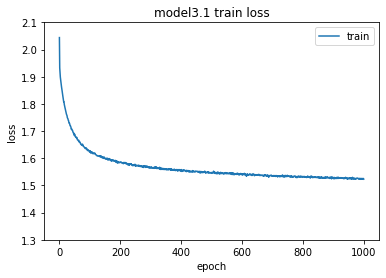

In [9]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.title('model3.1 train loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.ylim([1.3,2.1])
pyplot.legend(['train'], loc='upper right')

In [11]:
model.save('/home/wcb/nerXY/model/model3.1.h5')